In [1]:
import matplotlib.pyplot as plt
import numpy as np
from config.SC_config_1d import *
from config.config_1d import *
from utils_1d.data_utils import *
from utils_1d.solver_utils import *

In [2]:
## Load models
load_epoch =5000
chkpts_name_c_gen = cwd + '/mdls/' + save_name_c_gen + '_epoch_' + str(load_epoch) + '_ckpt.pth'
ckpt_c = torch.load(chkpts_name_c_gen)
model_c_gen.load_state_dict(ckpt_c)

C:\Users\wzhex\AppData\Local\Temp\ipykernel_37340\2675304089.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt_c = torch.load(chkpts_name_c_gen)


<All keys matched successfully>

In [3]:
### Load data
with open(Data_name, 'rb') as ss:
    real = np.load(ss)
    god = np.load(ss)
    lw = np.load(ss)
    cd = np.load(ss)
    fft = np.load(ss)

In [4]:
######### define problem type ###############
#type = 'pink'
type = 'lw'
bs = 50
np.random.seed(42)

if type == 'white' or type == 'pink' or type == 'brown':
    rows_to_delete = []
    for i in range(real.shape[0]):
        if np.max(np.abs(real[i, ...]))<1e-2:
            rows_to_delete.append(i)
            
    real = np.delete(real, rows_to_delete, axis=0)
real = real[:bs, ...]

if type == 'cd':
    test = cd[:bs, ...]
elif type == 'lw':
    test = lw[:bs, ...]
elif type == 'god':
    test = god[:bs, ...]
elif type == 'fft':
    test = fft[:bs, ...]
elif type == 'white':
    test = real[:bs, ...] + 0.1 * np.random.randn(*real[:bs, ...].shape)
elif type == 'pink':
    test = real[:bs, ...] + 0.1 * generate_batch_pink_noise_1d(bs, real.shape[1])
elif type == 'brown':
    test = real[:bs, ...] + 0.1 * generate_batch_pink_noise_1d(bs, real.shape[1], pinkness=2)

In [5]:
bpd = np.zeros((7, 4, bs))
ipd = np.zeros((7, 4, bs))

In [6]:
T_ls = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
for i, T in enumerate(T_ls):
    for metric in range(1, 5):
        if metric == 1:
            method = 'mmd'
            weight = False
            Method_name = 'MMD'
        elif metric == 2:
            method = 'spectral'
            weight = False
            Method_name = 'MELRu'
        elif metric == 3:
            method = 'spectral'
            weight = True
            Method_name = 'MELRw'
        elif metric == 4:
            method = 'w2'
            weight = False
            Method_name = 'W2'
            
        sigma = 0.01
        Ts = 0.01
        t_ls = np.linspace(Ts, T, 10)
        
        min, t = find_opt_t(test[..., None], real[..., None], marginal_prob_std_fn, t_ls, max_k=64, metric=method, weight=weight, sigma=sigma)
        
        min, t1, t2 = find_inter_t(test[..., None], real[..., None], marginal_prob_std_fn, t_ls, max_k=64, metric=method, weight=weight, sigma=sigma)
        
        Y_test = torch.from_numpy(test[:bs, ..., None]).float().to(device)
        
        transfer_sdit_test_imb = transfer_sdit(marginal_prob_std_fn, diffusion_coeff_fn, model_c_gen, Y_test, eps=1e-5, t1=t1, t2=t2)
        transfer_sdit_test_vani = transfer_sdit(marginal_prob_std_fn, diffusion_coeff_fn, model_c_gen, Y_test, eps=1e-5, t1=t, t2=t)
        
        error_vani2ref_tvd = compute_TVD_vec(transfer_sdit_test_vani, real[..., None])
        error_imb2ref_tvd = compute_TVD_vec(transfer_sdit_test_imb, real[..., None])
        
        #print(error_imb2ref_tvd.shape, error_vani2ref_tvd.shape)
        
        bpd[i, metric-1, ...] = error_vani2ref_tvd
        ipd[i, metric-1, ...] = error_imb2ref_tvd  

D:\pycharm\DCSR\utils_1d\train_sc_utils.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
D:\pycharm\DCSR\utils_1d\train_sc_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma ** t, device=device)


Number of function evaluations: 368
Number of function evaluations: 368


D:\pycharm\DCSR\utils_1d\data_utils.py:523: RuntimeWarning: divide by zero encountered in divide
  return np.sum(np.abs(pd - ref), axis=(1,2)) / np.sum(np.abs(ref), axis=(1,2))


Number of function evaluations: 332
Number of function evaluations: 320
Number of function evaluations: 350
Number of function evaluations: 356
Number of function evaluations: 326
Number of function evaluations: 290
Number of function evaluations: 416
Number of function evaluations: 404
Number of function evaluations: 332
Number of function evaluations: 338
Number of function evaluations: 344
Number of function evaluations: 374
Number of function evaluations: 320
Number of function evaluations: 290
Number of function evaluations: 530
Number of function evaluations: 416
Number of function evaluations: 344
Number of function evaluations: 290
Number of function evaluations: 338
Number of function evaluations: 416
Number of function evaluations: 332
Number of function evaluations: 296
Number of function evaluations: 464
Number of function evaluations: 434
Number of function evaluations: 332
Number of function evaluations: 404
Number of function evaluations: 344
Number of function evaluatio

D:\pycharm\DCSR\utils_1d\data_utils.py:451: RuntimeWarning: overflow encountered in exp
  return np.exp(-distances / (2 * sigma ** 2))


Number of function evaluations: 428
Number of function evaluations: 356
Number of function evaluations: 326
Number of function evaluations: 458
Number of function evaluations: 350
Number of function evaluations: 296
Number of function evaluations: 326
Number of function evaluations: 290
Number of function evaluations: 344
Number of function evaluations: 296
Number of function evaluations: 332
Number of function evaluations: 398
Number of function evaluations: 350
Number of function evaluations: 440
Number of function evaluations: 344
Number of function evaluations: 296
Number of function evaluations: 404
Number of function evaluations: 422
Number of function evaluations: 326
Number of function evaluations: 296
Number of function evaluations: 368
Number of function evaluations: 422
Number of function evaluations: 332
Number of function evaluations: 290


In [7]:
bpd_mmd, bpd_melru, bpd_melrw, bpd_w2 = bpd[:, 0, ...], bpd[:, 1, ...], bpd[:, 2, ...], bpd[:, 3, ...]
ipd_mmd, ipd_melru, ipd_melrw, ipd_w2 = ipd[:, 0, ...], ipd[:, 1, ...], ipd[:, 2, ...], ipd[:, 3, ...]

In [8]:
mean_bpd_mmd = np.mean(bpd_mmd, axis=1)
var_bpd_mmd = np.var(bpd_mmd, axis=1)

mean_bpd_melru = np.mean(bpd_melru, axis=1)
var_bpd_melru = np.var(bpd_melru, axis=1)

mean_bpd_melrw = np.mean(bpd_melrw, axis=1)
var_bpd_melrw = np.var(bpd_melrw, axis=1)

mean_bpd_w2 = np.mean(bpd_w2, axis=1)
var_bpd_w2 = np.var(bpd_w2, axis=1)

###########################################

mean_ipd_mmd = np.mean(ipd_mmd, axis=1)
var_ipd_mmd = np.var(ipd_mmd, axis=1)

mean_ipd_melru = np.mean(ipd_melru, axis=1)
var_ipd_melru = np.var(ipd_melru, axis=1)

mean_ipd_melrw = np.mean(ipd_melrw, axis=1)
var_ipd_melrw = np.var(ipd_melrw, axis=1)

mean_ipd_w2 = np.mean(ipd_w2, axis=1)
var_ipd_w2 = np.var(ipd_w2, axis=1)

C:\Users\wzhex\anaconda3\envs\torch_gpu\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


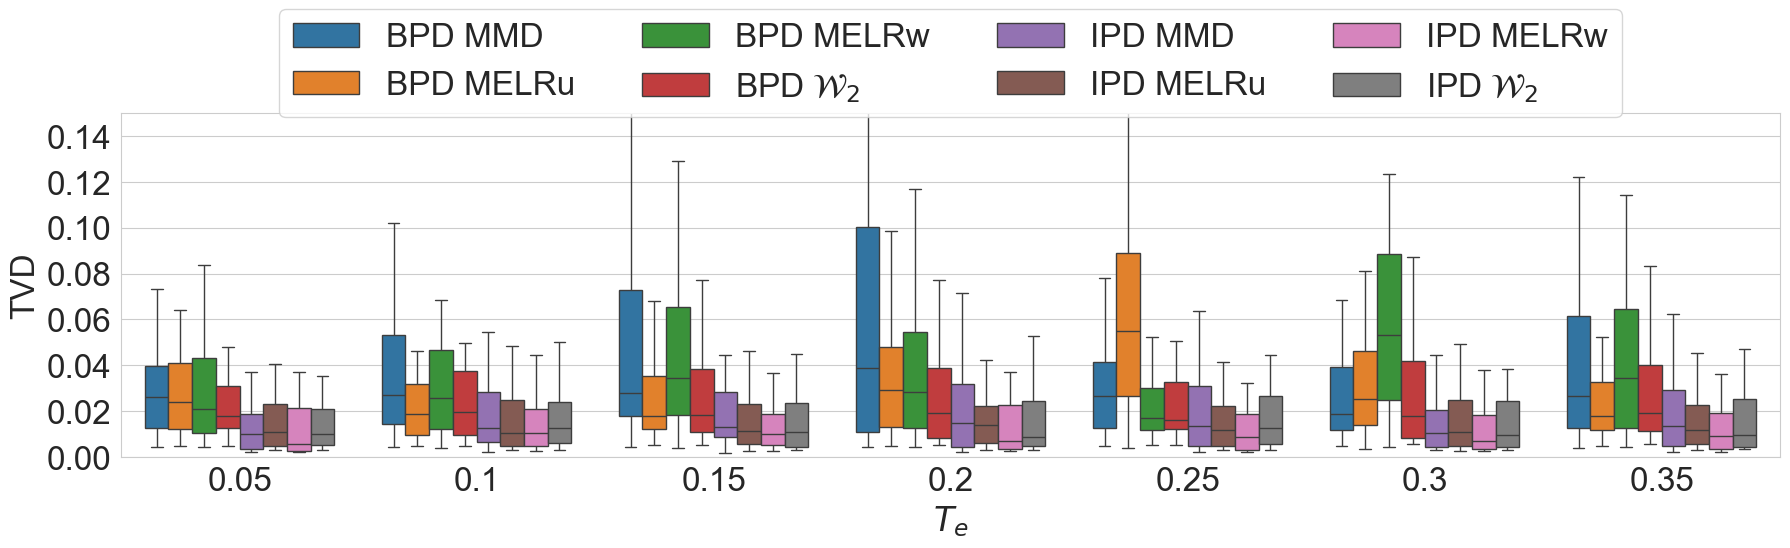

In [11]:
import seaborn as sns
import numpy as np
import pandas as pd

fig_name = 'figs/ablation_'+type + '.png'

data_combined = np.concatenate([bpd, ipd], axis=1)
class_names = ["BPD MMD", "BPD MELRu", "BPD MELRw", r"BPD $\mathcal{W}_2$",
               "IPD MMD", "IPD MELRu", "IPD MELRw", r"IPD $\mathcal{W}_2$"]
data_for_plotting = {
    'Timestep': [],
    'Class': [],
    'TVD': []
}
for i, t in enumerate(T_ls):
    for j, class_name in enumerate(class_names):  # Iterate over named classes
        accuracies = data_combined[i, j, :]  # Extract data for this timestep and class
        data_for_plotting['Timestep'].extend([t] * len(accuracies))
        data_for_plotting['Class'].extend([class_name] * len(accuracies))
        data_for_plotting['TVD'].extend(accuracies.tolist())

# Convert to a DataFrame
df = pd.DataFrame(data_for_plotting)

plt.figure(figsize=(18, 6))
sns.boxplot(x='Timestep', y='TVD', hue='Class', data=df, showfliers=False)

# Customization
plt.xlabel('$T_e$', fontsize=24)
plt.ylabel('TVD', fontsize=24)
plt.ylim([0, 0.15])
#plt.title('Boxplots of TVD for Named Classes Across Timesteps', fontsize=14)
#legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', fontsize=10)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=4, fontsize=24)  # Adjust position and layout
#plt.legend([], [], frameon=False)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.tight_layout()
plt.savefig(fig_name, bbox_inches='tight')
# Show plot
plt.show()